**URL:**

https://www.eneos.co.jp/english/newsrelease/

In [1]:
#libraries
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#site name , domain and site link
SITE_NAME='Eneos'

DOMAIN = "https://www.eneos.co.jp/english"

SITE_LINK = "https://www.eneos.co.jp/english/newsrelease"

In [42]:
#functions
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(string):
    review = re.sub('''[^a-zA-Z0-9!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~°]''', ' ',string)
    review = review.split()
    review = ' '.join(review)
    return review

def get_text(link): 
    g = Goose()
    article_extract = g.extract(url=link)
    article = remove_esc_chars(article_extract.cleaned_text)
    meta_data = remove_esc_chars(article_extract.meta_description)
    whole_data = meta_data+article
    text = whole_data.strip()

    if textstat.lexicon_count(text, removepunct=True) < 5:
        try:
            response = requests.get(link)
            text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

            if textstat.lexicon_count(text, removepunct=True) < 5:
                texts = ""
                r = requests.get(link)
                filename = Path('temp.pdf')
                filename.write_bytes(r.content)

                pages = convert_from_path('temp.pdf', 500)
                for x in pages:
                    x.save("temp.jpg")
                    output = reader.readtext("temp.jpg")
                    for o in output:
                        texts += o[1]

                text = remove_esc_chars(texts)

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    soup = parse_webpage_bs(link)
                    if soup!= None:
                        ps = soup.findAll('p')
                        for p in ps:
                            texts+= p.text

                    text = remove_esc_chars(texts)
        except:
            text = ""
    
    return text

In [76]:
article_list = []
pagination = datetime.today().year
last_page = 2003

while pagination >= last_page:
    #deciding the url
    if pagination <= 2009:
        url = f"https://www.eneos.co.jp/english/newsrelease/noc/{pagination}/"
    elif pagination <= 2016 :
        url = f"https://www.eneos.co.jp/english/newsrelease/jx/{pagination}/"
    else:
        url = f"https://www.eneos.co.jp/english/newsrelease/{pagination}/"

    #getting the soup
    soup = parse_webpage_bs(url)
    print()
    print(url)
    
    #container of elements
    elements = soup.findAll('article', {'class': 'news_article'})

    #creating empty lists to append data 
    published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]

    for element in tqdm(elements[:2],desc=f"Getting Data for year {pagination}"):
        published_date_n_title = element.find('div', {'class': 'news_detail'})
        published_date  = published_date_n_title.find('div', {'class': 'news_property'}).text.strip()
        title = published_date_n_title.find('h3', {'class': 'news_title'}).text.strip()
        link_fetched = element.find('a')['href']
        if not re.findall("http",link_fetched):
            link =  "https://www.eneos.co.jp" +  link_fetched
        else:
            link = link_fetched

        thumbnail = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/ENEOS_logo.svg/330px-ENEOS_logo.svg.png"
        author = SITE_NAME
        text = get_text(link)

        published_dates.append(published_date)
        titles.append(title)
        links.append(link)
        thumbnails.append(thumbnail)
        authors.append(author)
        texts.append(text)

    #zippig all the data togather 
    zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))

    #unwinding and appending to the main list
    for published_date,title,text,link,thumbnail,author in zipped:
        article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
        article_list.append(article)
        print(published_date,title)
        
#     #my condition to break
#     if pagination == 2018:
#         break

    pagination -=1 


https://www.eneos.co.jp/english/newsrelease/2022/


Getting Data for year 2022:   0%|          | 0/2 [00:00<?, ?it/s]

Jun. 7, 2022 Joint Study Agreement formed to evaluate development of clean hydrogen supply chain between UAE and Japan
May 25, 2022 Partnership Agreement Signed to Expand CO2-free Hydrogen Use to Decarbonize Railways

https://www.eneos.co.jp/english/newsrelease/2021/


Getting Data for year 2021:   0%|          | 0/2 [00:00<?, ?it/s]

Mar. 23, 2022 ENEOS, Toyota, and Woven Planet Collaborate to Facilitate CO2-free Hydrogen Production and Usage for Woven City and Beyond
Feb. 18, 2022 Bridgestone and ENEOS Launch Joint Project Focused on Producing Tire Raw Materials from Used Tires

https://www.eneos.co.jp/english/newsrelease/2020/


Getting Data for year 2020:   0%|          | 0/2 [00:00<?, ?it/s]

Mar. 25, 2021 ENEOS signs MoU with Aramco for blue hydrogen and blue ammonia collaboration
Feb. 25, 2021 Enhancement of Business Promotion in Vietnam

https://www.eneos.co.jp/english/newsrelease/2019/


Getting Data for year 2019:   0%|          | 0/2 [00:00<?, ?it/s]

Feb. 25, 2020 Feasibility Study on Production and Sales of Sustainable Aviation Fuel Made from Plastic and Other Waste Materials
Jan. 9, 2020 Business Operations of New Lubricants Sales Entity to Start in the Republic of the Philippines

https://www.eneos.co.jp/english/newsrelease/2018/


Getting Data for year 2018:   0%|          | 0/2 [00:00<?, ?it/s]

Mar. 15, 2019 Succeeded in the world's first technical verification to produce "CO2-free hydrogen" at low cost
Sep. 6, 2018 Memorandum of Understanding Regarding Replacement Plan for the Goi Thermal Power Station

https://www.eneos.co.jp/english/newsrelease/2017/


Getting Data for year 2017:   0%|          | 0/2 [00:00<?, ?it/s]

Mar. 29, 2018 Sale of part of High Performance Materials business
Sep. 20, 2017 Donation to Hurricane Harvey Relief in the US

https://www.eneos.co.jp/english/newsrelease/jx/2016/


Getting Data for year 2016:   0%|          | 0/2 [00:00<?, ?it/s]

Jan. 23, 2017 PETRONAS LNG 9 Sdn Bhd (PL9SB) commences commercial operations
Jun. 27, 2016 The expansion of PIB plant

https://www.eneos.co.jp/english/newsrelease/jx/2015/


Getting Data for year 2015:   0%|          | 0/2 [00:00<?, ?it/s]

March 30, 2016 Individual Sponsorship for the MotoGP Rider Mr. Valentino Rossi
January 8, 2016 Irvine Scientific acquires BioCare Europe S.r.l.

https://www.eneos.co.jp/english/newsrelease/jx/2014/


Getting Data for year 2014:   0%|          | 0/2 [00:00<?, ?it/s]

March 18, 2015 JX Nippon Oil & Energy Becomes Tokyo 2020 Gold Partner
February 19, 2015 SPONSORSHIP OF BOSTON RED SOX

https://www.eneos.co.jp/english/newsrelease/jx/2013/


Getting Data for year 2013:   0%|          | 0/2 [00:00<?, ?it/s]

March 20, 2014 Signing of SPA with Malaysia LNG Sdn. Bhd.
December 16, 2013 Donation for the Construction of a New Elementary School Building in Vietnam

https://www.eneos.co.jp/english/newsrelease/jx/2012/


Getting Data for year 2012:   0%|          | 0/2 [00:00<?, ?it/s]

December 20, 2012 JAPAN-GTL Process wonThe Japan Institute of Energy Award 2012 in Technical Division
October 18, 2012 The new project of ENB plant in Thailand

https://www.eneos.co.jp/english/newsrelease/jx/2011/


Getting Data for year 2011:   0%|          | 0/2 [00:00<?, ?it/s]

March 14, 2012 Xstrata Coal and JX Nippon Oil & Energy Announce Creation of a Canadian Metallurgical Coal Joint Venture
February 16, 2012 Signing of SPA with Shell Eastern Trading Pte Ltd

https://www.eneos.co.jp/english/newsrelease/jx/2010/


Getting Data for year 2010:   0%|          | 0/2 [00:00<?, ?it/s]

January 13, 2011 13 Japanese Companies Eye Smooth Domestic Launch of FCVs
January 7, 2011 JI Project with Gazprom Realizes 290K Tons (CO2 Equivalent) in Emissions Credits

https://www.eneos.co.jp/english/newsrelease/noc/2009/


Getting Data for year 2009:   0%|          | 0/2 [00:00<?, ?it/s]

2010.02.26 Notice Concerning Assignment of Fixed Assets
2010.02.22 Production to be Launched in Europe of Astaxanthin for use in Fish Feed

https://www.eneos.co.jp/english/newsrelease/noc/2008/


Getting Data for year 2008:   0%|          | 0/2 [00:00<?, ?it/s]

2009.03.13 Personnel Changes
2009.02.27 Notice of Changes in Schedule of Management Integration

https://www.eneos.co.jp/english/newsrelease/noc/2007/


Getting Data for year 2007:   0%|          | 0/2 [00:00<?, ?it/s]

2008.03.18 memorandum for a business integration
2008.02.29 Rang Dong Project in Vietnam Receives CER Issuance Approval Under the Kyoto Protocol

https://www.eneos.co.jp/english/newsrelease/noc/2006/


Getting Data for year 2006:   0%|          | 0/2 [00:00<?, ?it/s]

2007.02.22 Nippon Oil and SK of Korea to Develop Strategic Business and Capital Alliances
2006.08.29 CSR Report 2006

https://www.eneos.co.jp/english/newsrelease/noc/2005/


Getting Data for year 2005:   0%|          | 0/2 [00:00<?, ?it/s]

2006.02.07 Rang Dong Oil Field associated gas recovery and utilization project approved as a Clean Development Mechanism Project under the Kyoto Protocol.
2005.12.19 Notice Regarding Three-Party Agreement

https://www.eneos.co.jp/english/newsrelease/noc/2004/


Getting Data for year 2004:   0%|          | 0/2 [00:00<?, ?it/s]

2005.03.30 Commencement of Commercial Oil Production from the Mutineer-Exeter Oil Fields, Offshore North-Western Australia
2005.02.24 Lubricants Partner Contract Signed with the B•A•R Honda F1 Team

https://www.eneos.co.jp/english/newsrelease/noc/2003/


Getting Data for year 2003:   0%|          | 0/2 [00:00<?, ?it/s]

2004.03.26 Announcement of Early Application of Fixed Asset Impairment Accounting and Revisions in Forecast for Nippon Oil
2003.11.25 Commencement of Production from Helang Gas Field


In [77]:
#temp df
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,"Jun. 7, 2022",Joint Study Agreement formed to evaluate devel...,"June 7th, 2022 Abu Dhabi National Oil Company ...",https://www.eneos.co.jp/english/newsrelease/20...,https://upload.wikimedia.org/wikipedia/commons...,Eneos
1,"May 25, 2022",Partnership Agreement Signed to Expand CO2-fre...,"May 25, 2022 East Japan Railway Company ENEOS ...",https://www.eneos.co.jp/english/newsrelease/20...,https://upload.wikimedia.org/wikipedia/commons...,Eneos
2,"Mar. 23, 2022","ENEOS, Toyota, and Woven Planet Collaborate to...","March 23, 2022 ENEOS Corporation Toyota Motor ...",https://www.eneos.co.jp/english/newsrelease/20...,https://upload.wikimedia.org/wikipedia/commons...,Eneos
3,"Feb. 18, 2022",Bridgestone and ENEOS Launch Joint Project Foc...,For Immediate Release Bridgestone Corporation ...,https://www.eneos.co.jp/english/newsrelease/20...,https://upload.wikimedia.org/wikipedia/commons...,Eneos
4,"Mar. 25, 2021",ENEOS signs MoU with Aramco for blue hydrogen ...,"March 25, 2021 ENEOS Corporation ENEOS signs M...",https://www.eneos.co.jp/english/newsrelease/20...,https://upload.wikimedia.org/wikipedia/commons...,Eneos


Jan. 23, 2017 PETRONAS LNG 9 Sdn Bhd (PL9SB) commences commercial operations

Eneos https://www.eneos.co.jp/english/newsrelease/jx/2016/pdf/20170123_01.pdf


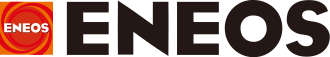


Jan 23, 2017 PETRONAS LNG 9 Sdn Bhd (PL9SB) commences commercial operations Tokyo, 23rd January 2017 - JX Nippon Oil & Energy (JX NOE) is pleased to announce that PETRONAS LNG 9 Sdn Bhd (PL9SB) commenced commercial operations on 1st January. Last June, JX NOE purchased a 10 per cent stake in PL9SB, which owns the ninth LNG liquefaction train within the PETRONAS LNG Complex in Bintulu, Sarawak, Malaysia. The train has a production capacity of 3.6 million tonnes per annum. JX NOE s entry into PL9SB marked its second participation in PETRONAS LNG projects, in addition to its existing 10 per cent equity interest in MLNG Tiga Sdn Bhd. With the addition of the state-of-the-art liquefaction plant owned by PL9SB, the PETRONAS LNG Complex now has the capacity to produce approximately 30 million tonnes per annum. The strategic partnership of JX NOE and PETRONAS will strive towards expanding the LNG business and ensuring a reliable supply of energy for the customers. Aerial view of PETRONAS LNG 

In [78]:
#see data
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [79]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [80]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
